In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [3]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Скачиваем данные

In [59]:
interesting_tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG', 'HD', 'IP', 'TSLA', 'F', 'HP', 'NVDA',
           'AMZN', 'AAL', 'NFLX', 'AMD', 'FCF', 'FSD', 'FLS', 'FC', 'FT', 'BA',
           'SHOP', 'JNJ', 'XOM', 'META', 'WMT', 'JPM', 'PFE', 'BABA', 'DIS', 'INTC',
           'MCD', 'GM', 'HPQ', 'BMO', 'PEP', 'ORCL', 'BAC', 'LVS', 'TWTR', 'ABBV',
           'SWN', 'SBUX', 'WFC', 'EBAY', 'ATVI', 'NTDOY', 'UBSFY', 'AZN', 'SNY', 
           'BAYRY', 'SHEL', 'ENB', 'SLB' 
           ]
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):  #tqdm - помогает понять, сколько уже сделано (визуальная строка загрузки)
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1y', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df_0 = pd.DataFrame(full_ticker_data)
    full_ticker_df = pd.DataFrame(full_ticker_df_0.iloc[:,1:].pct_change(axis='columns'))
    full_ticker_df.insert(0, "shortName", full_ticker_df_0.shortName)
    full_ticker_df.to_csv("/kravets/CMF/pr1/file.csv")

else: 
    full_ticker_df = pd.read_csv("/kravets/CMF/pr1/file.csv", index_col=0, encoding= 'unicode_escape', error_bad_lines=False)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [60]:
full_ticker_df.shape

(53, 253)

In [61]:
full_ticker_df.head()

shortName  2021-10-07 00:00:00-04:00  \
0                       Apple Inc.                        NaN   
1            Microsoft Corporation                        NaN   
2  International Business Machines                        NaN   
3                    Alphabet Inc.                        NaN   
4           Home Depot, Inc. (The)                        NaN   

   2021-10-08 00:00:00-04:00  2021-10-11 00:00:00-04:00  \
0                  -0.002722                  -0.000630   
1                   0.000000                  -0.002103   
2                   0.009943                  -0.005516   
3                   0.006254                  -0.008629   
4                  -0.009304                   0.007866   

   2021-10-12 00:00:00-04:00  2021-10-13 00:00:00-04:00  \
0                  -0.009103                  -0.004240   
1                  -0.004588                   0.011711   
2                  -0.013761                   0.002065   
3                  -0.015373                   0.008682   
4                   0.002463                   0.001421   

   2021-10-14 00:00:00-04:00  2021-10-15 00:00:00-04:00  \
0                   0.020226                   0.007513   
1                   0.021734                   0.004822   
2                   0.018684                   0.008508   
3                   0.025468                   0.001860   
4                   0.017057                   0.018486   

   2021-10-18 00:00:00-04:00  2021-10-19 00:00:00-04:00  ...  \
0                   0.011806                   0.015080  ...   
1                   0.010125                   0.003059  ...   
2                  -0.015836                  -0.002389  ...   
3                   0.009074                   0.006026  ...   
4                   0.013127                   0.008394  ...   

   2022-09-23 00:00:00-04:00  2022-09-26 00:00:00-04:00  \
0                  -0.015124                   0.002260   
1                  -0.012698                  -0.001975   
2                  -0.020749                  -0.005704   
3                  -0.013921                  -0.003630   
4                   0.006688                  -0.016092   

   2022-09-27 00:00:00-04:00  2022-09-28 00:00:00-04:00  \
0                   0.006566                  -0.012652   
1                  -0.004380                   0.019712   
2                  -0.002213                   0.008379   
3                  -0.007287                   0.027016   
4                   0.007915                   0.050244   

   2022-09-29 00:00:00-04:00  2022-09-30 00:00:00-04:00  \
0                  -0.049119                  -0.030039   
1                  -0.014809                  -0.019368   
2                  -0.009205                  -0.023185   
3                  -0.026305                  -0.019778   
4                  -0.013679                  -0.008587   

   2022-10-03 00:00:00-04:00  2022-10-04 00:00:00-04:00  \
0                   0.030753                   0.025623   
1                   0.033663                   0.033812   
2                   0.022725                   0.032837   
3                   0.032761                   0.031319   
4                   0.028122                   0.020656   

   2022-10-05 00:00:00-04:00  2022-10-06 00:00:00-04:00  
0                   0.002053                  -0.006626  
1                   0.001286                  -0.009671  
2                   0.001912                  -0.027915  
3                  -0.001855                   0.000196  
4                   0.001002                   0.001863  

[5 rows x 253 columns]

In [62]:
full_ticker_df.isnull().sum(axis=1)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
dtype: int64

In [72]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [73]:
full_ticker_df.shape

(53, 251)

In [74]:
full_ticker_df

shortName  2021-10-08 00:00:00-04:00  \
0                        Apple Inc.                  -0.002722   
1             Microsoft Corporation                   0.000000   
2   International Business Machines                   0.009943   
3                     Alphabet Inc.                   0.006254   
4            Home Depot, Inc. (The)                  -0.009304   
5       International Paper Company                   0.002396   
6                       Tesla, Inc.                  -0.010232   
7                Ford Motor Company                   0.015446   
8           Helmerich & Payne, Inc.                   0.008847   
9                NVIDIA Corporation                  -0.011578   
10                 Amazon.com, Inc.                  -0.004182   
11    American Airlines Group, Inc.                  -0.004958   
12                    Netflix, Inc.                   0.001282   
13     Advanced Micro Devices, Inc.                  -0.013058   
14                            First                  -0.000696   
15  First Trust High Income Long Sh                  -0.003133   
16            Flowserve Corporation                  -0.001973   
17           Franklin Covey Company                   0.002567   
18         Franklin Universal Trust                   0.001219   
19             Boeing Company (The)                  -0.000397   
20                     Shopify Inc.                  -0.014637   
21                Johnson & Johnson                  -0.002541   
22          Exxon Mobil Corporation                   0.025058   
23             Meta Platforms, Inc.                   0.002521   
24                     Walmart Inc.                   0.003016   
25            JP Morgan Chase & Co.                   0.000764   
26                     Pfizer, Inc.                  -0.006785   
27    Alibaba Group Holding Limited                   0.035385   
28        Walt Disney Company (The)                  -0.005458   
29                Intel Corporation                  -0.006829   
30           McDonald's Corporation                  -0.002497   
31           General Motors Company                   0.037739   
32                          HP Inc.                  -0.005704   
33                 Bank Of Montreal                   0.012167   
34                    Pepsico, Inc.                  -0.002302   
35               Oracle Corporation                   0.026090   
36      Bank of America Corporation                   0.004986   
37            Las Vegas Sands Corp.                   0.029634   
38                    Twitter, Inc.                  -0.004533   
39                      AbbVie Inc.                   0.002796   
40      Southwestern Energy Company                  -0.021033   
41            Starbucks Corporation                  -0.008823   
42            Wells Fargo & Company                   0.005025   
43                        eBay Inc.                   0.011865   
44         Activision Blizzard, Inc                   0.003232   
45  NINTENDO CO LTD UNSP ADS EACH R                  -0.005119   
46  UBISOFT ENTERTAINMENT UNSP ADR                    0.004484   
47                  Astrazeneca PLC                   0.003976   
48                           Sanofi                   0.008436   
49  BAYER AG SPON ADR EACH REP 0.25                   0.030081   
50            Royal Dutch Shell PLC                   0.011731   
51                     Enbridge Inc                   0.013971   
52                Schlumberger N.V.                   0.020632   

    2021-10-11 00:00:00-04:00  2021-10-12 00:00:00-04:00  \
0                   -0.000630                  -0.009103   
1                   -0.002103                  -0.004588   
2                   -0.005516                  -0.013761   
3                   -0.008629                  -0.015373   
4                    0.007866                   0.002463   
5                    0.025005                  -0.000179   
6                    0.008212            

In [75]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

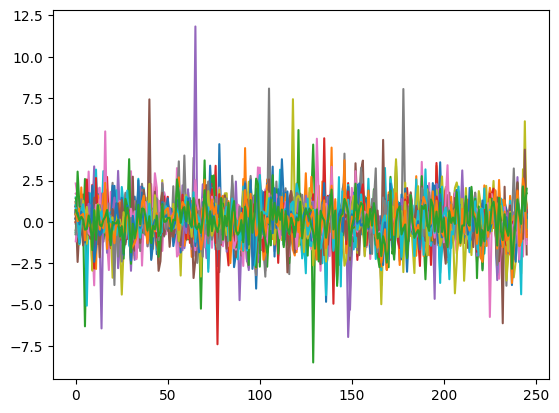

In [76]:
plt.plot(tickers_scaled.T);

100%|██████████| 18/18 [00:03<00:00,  5.25it/s]


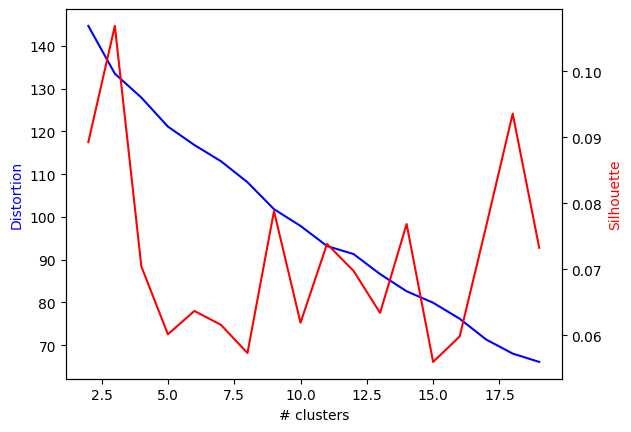

In [85]:
distortions = []
silhouette = []
K = range(2, 20)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [87]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_jobs=6)

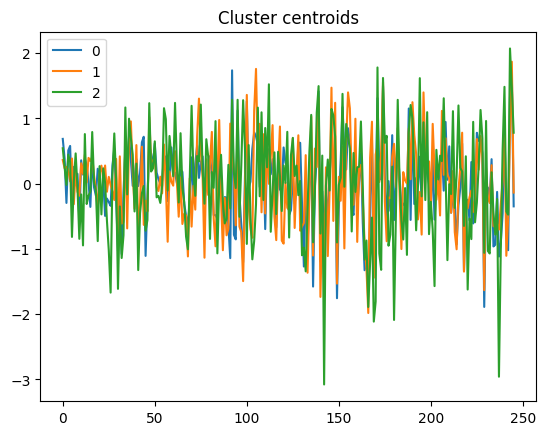

In [89]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [97]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [98]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)

                          Cluster number: 0


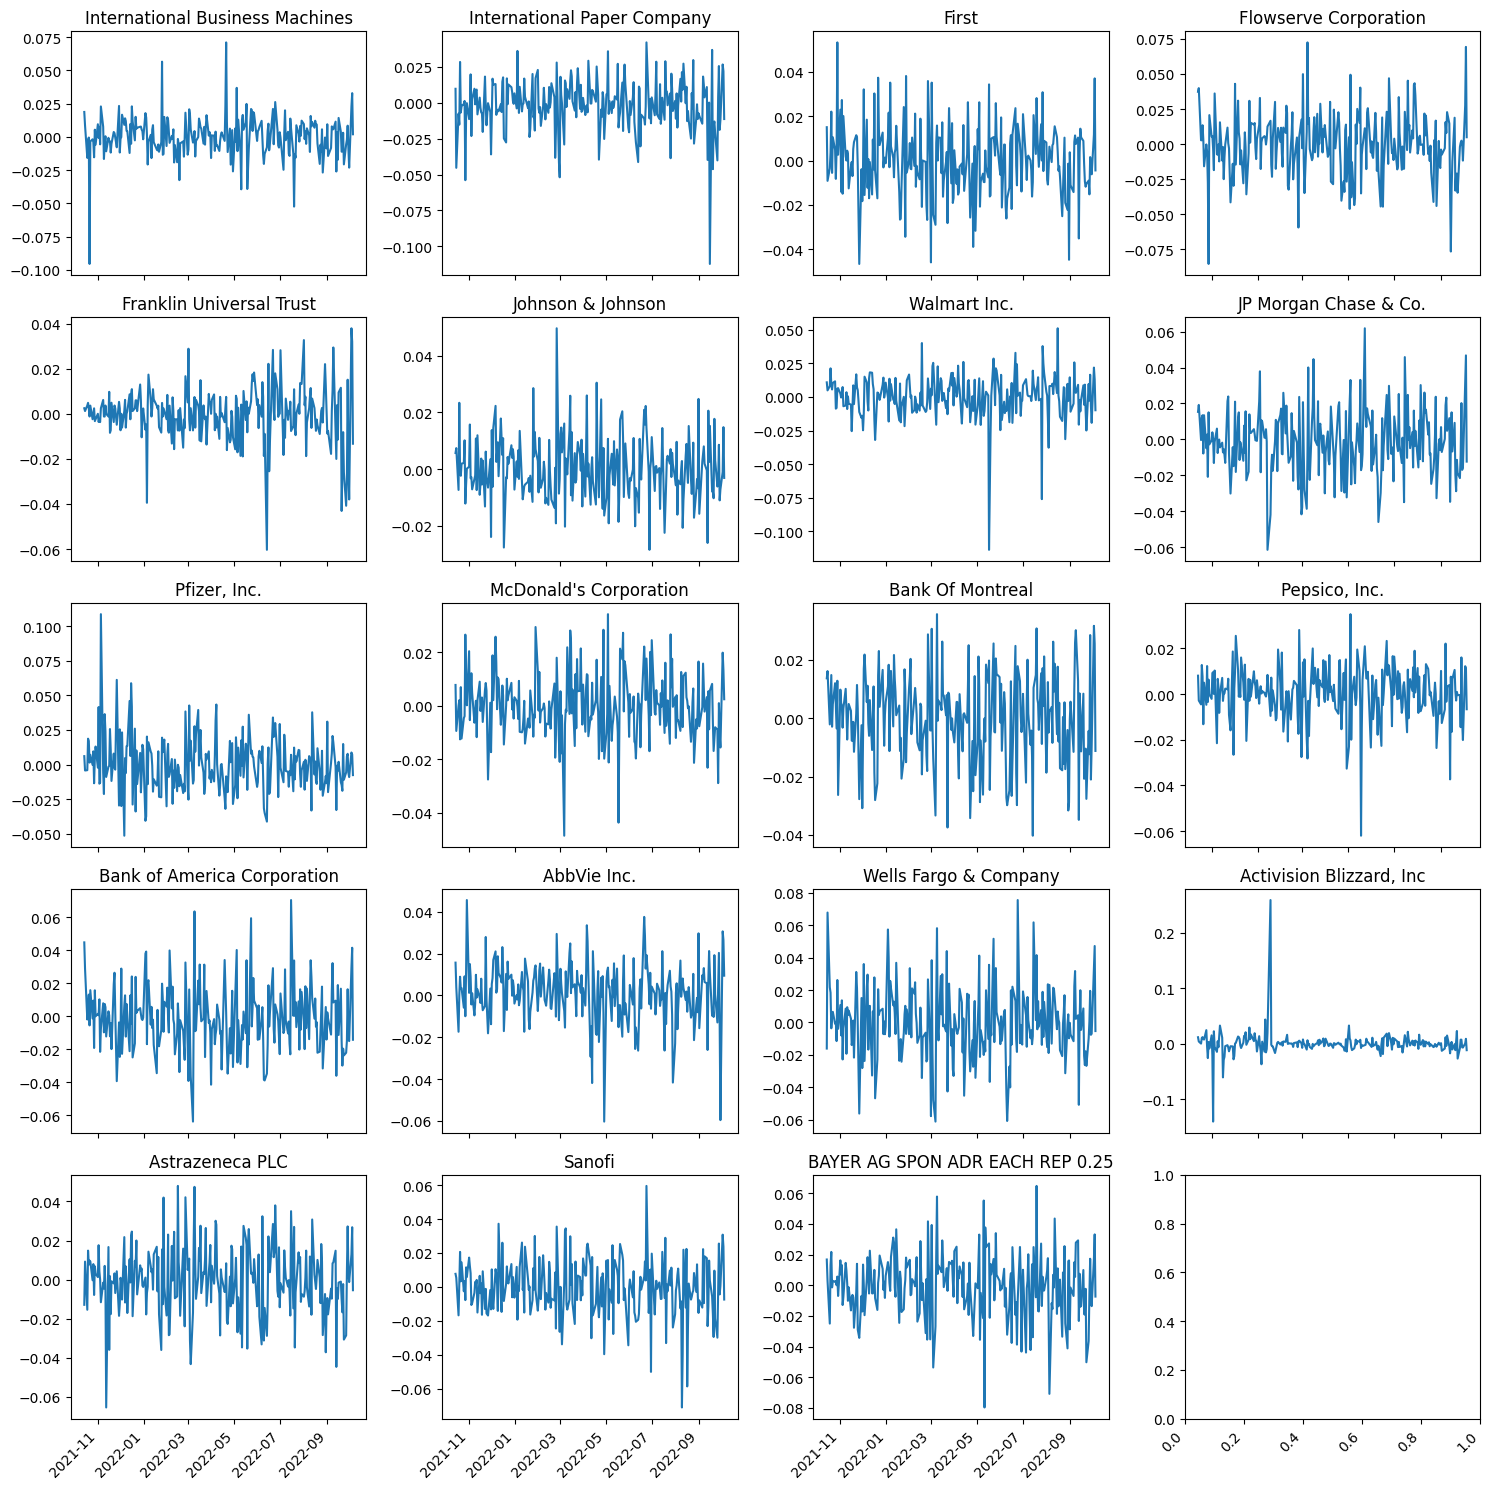

                          Cluster number: 1


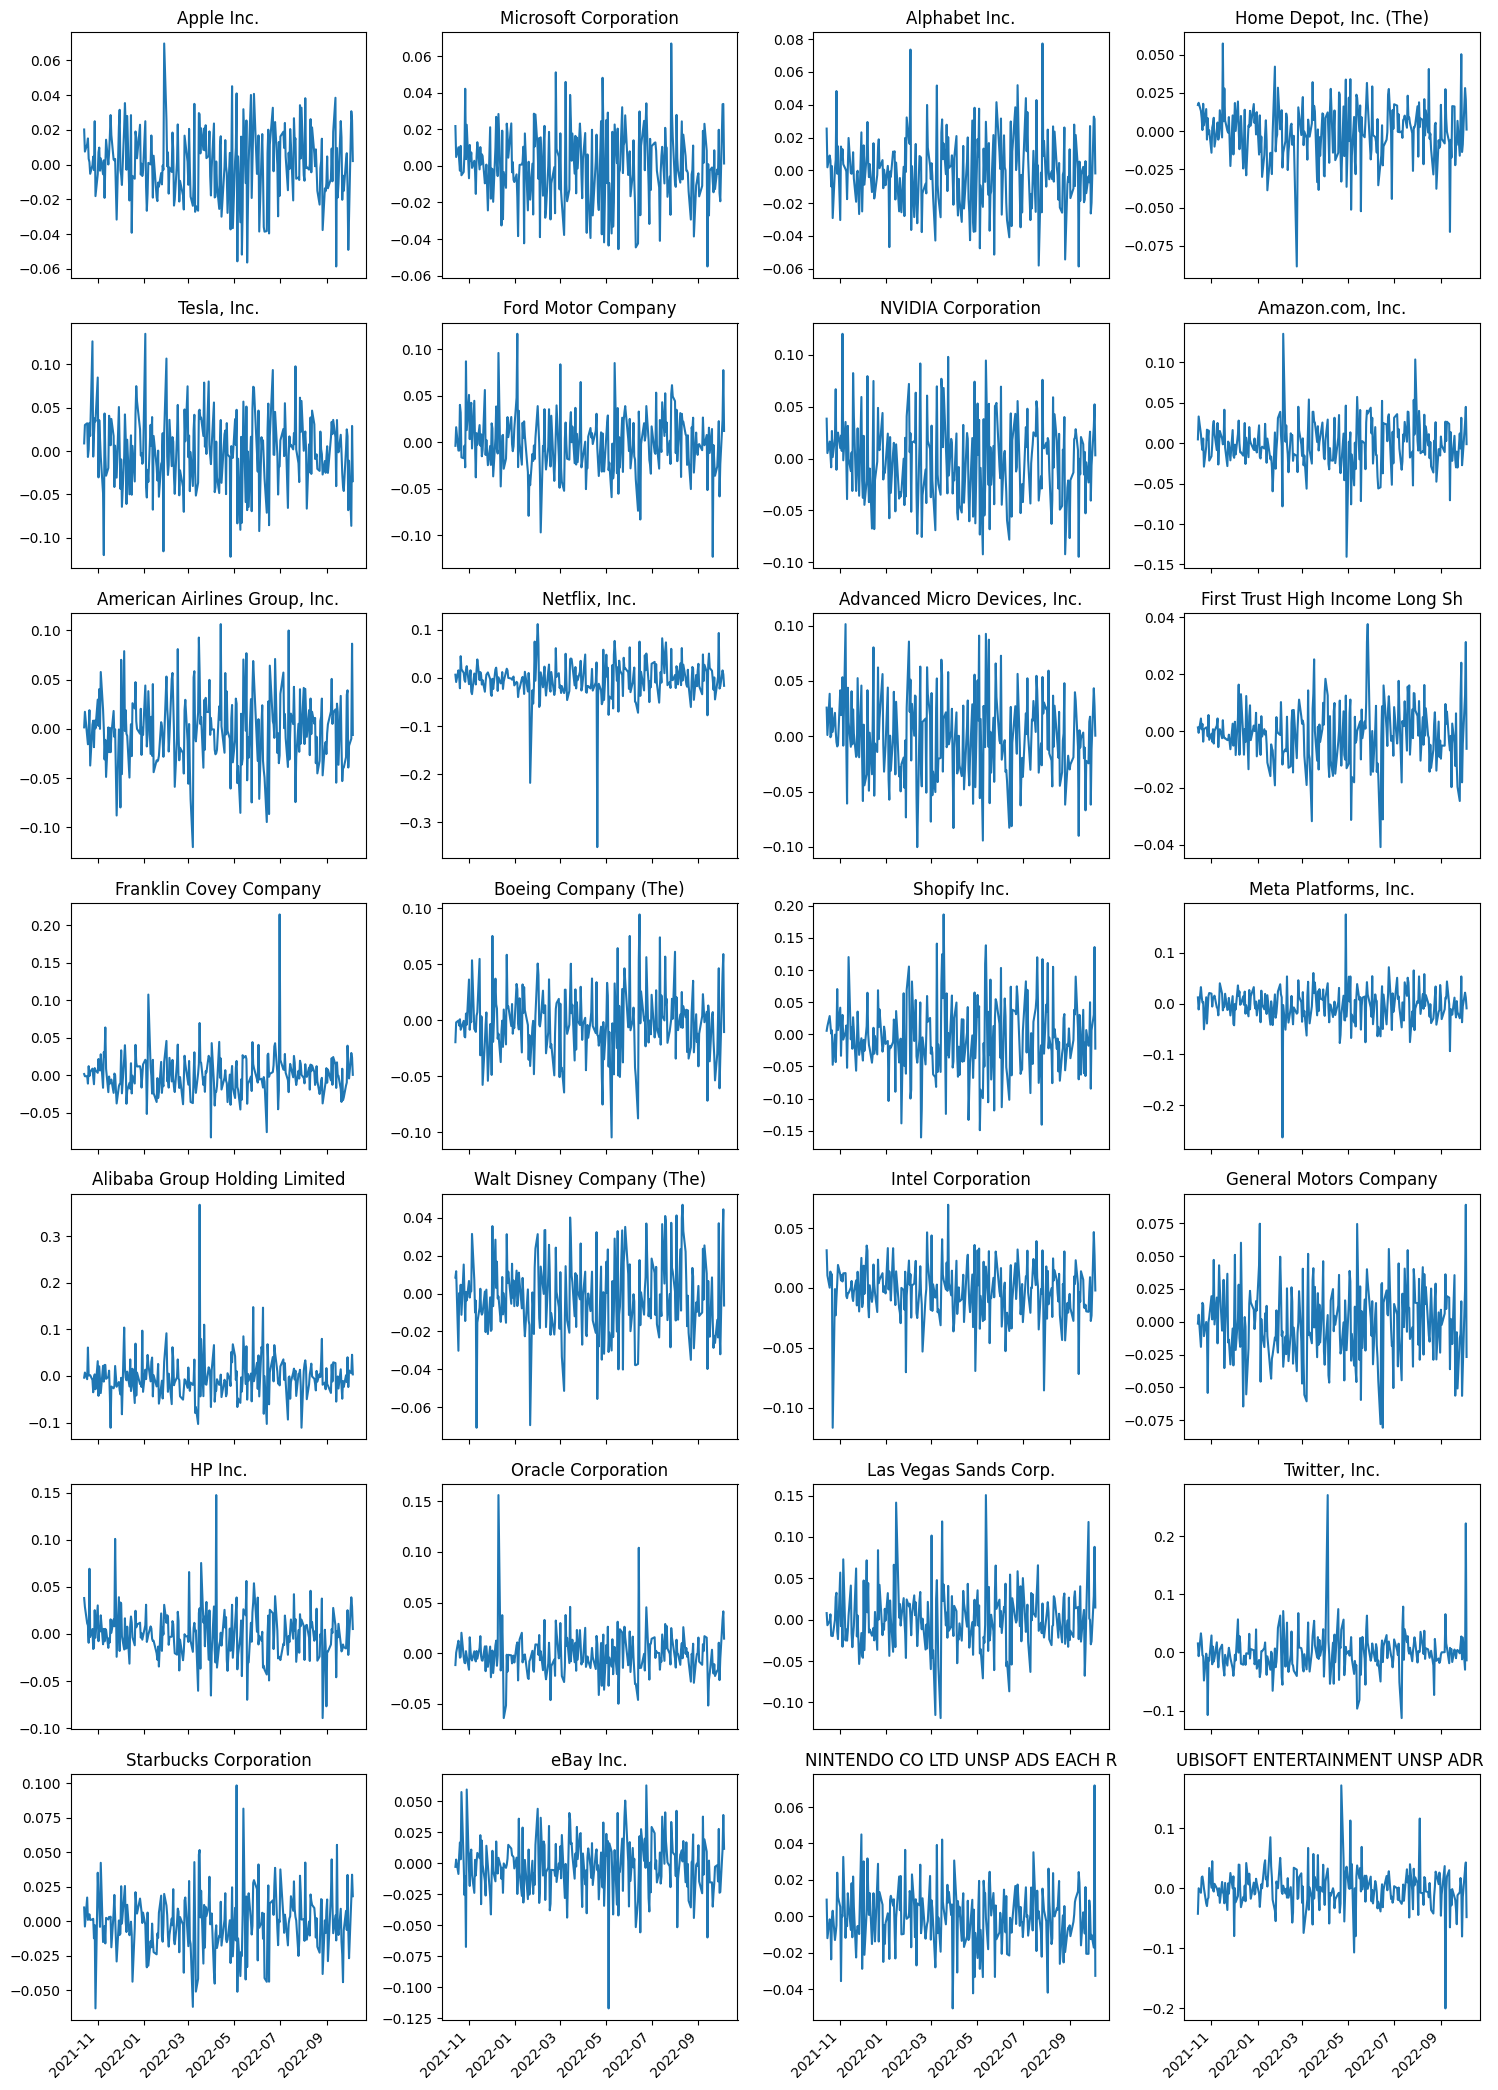

                          Cluster number: 2


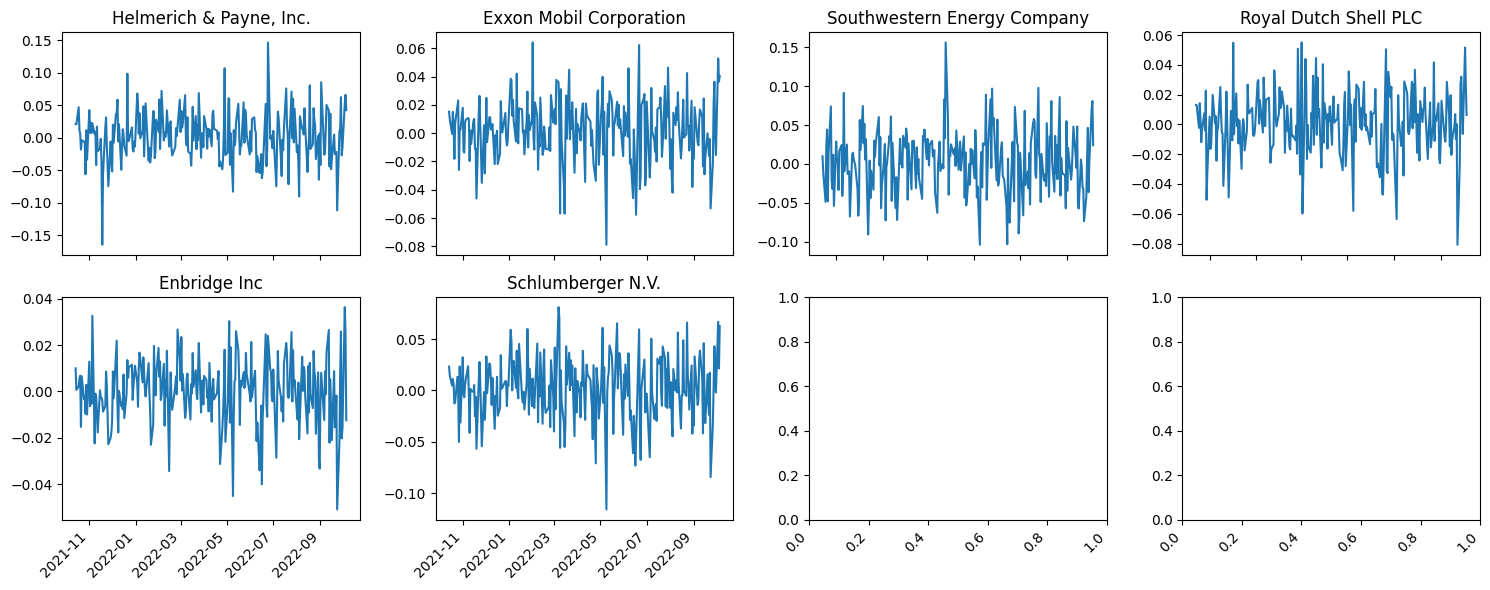

In [99]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

Иерархическая кластеризация

In [100]:
full_ticker_df_2 = full_ticker_df
link = linkage(full_ticker_df_2.iloc[:,2:], 'ward', 'euclidean')

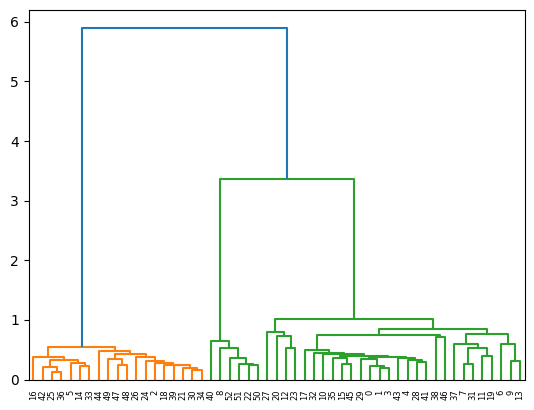

In [101]:
dn = dendrogram(link, orientation='top')
full_ticker_df_2['cluster'] = fcluster(link, 2, criterion='maxclust')

In [102]:
full_ticker_df_2.head()

shortName  2021-10-08 00:00:00-04:00  \
0                       Apple Inc.                  -0.002722   
1            Microsoft Corporation                   0.000000   
2  International Business Machines                   0.009943   
3                    Alphabet Inc.                   0.006254   
4           Home Depot, Inc. (The)                  -0.009304   

   2021-10-11 00:00:00-04:00  2021-10-12 00:00:00-04:00  \
0                  -0.000630                  -0.009103   
1                  -0.002103                  -0.004588   
2                  -0.005516                  -0.013761   
3                  -0.008629                  -0.015373   
4                   0.007866                   0.002463   

   2021-10-13 00:00:00-04:00  2021-10-14 00:00:00-04:00  \
0                  -0.004240                   0.020226   
1                   0.011711                   0.021734   
2                   0.002065                   0.018684   
3                   0.008682                   0.025468   
4                   0.001421                   0.017057   

   2021-10-15 00:00:00-04:00  2021-10-18 00:00:00-04:00  \
0                   0.007513                   0.011806   
1                   0.004822                   0.010125   
2                   0.008508                  -0.015836   
3                   0.001860                   0.009074   
4                   0.018486                   0.013127   

   2021-10-19 00:00:00-04:00  2021-10-20 00:00:00-04:00  ...  \
0                   0.015080                   0.003361  ...   
1                   0.003059                  -0.002660  ...   
2                  -0.002389                  -0.000563  ...   
3                   0.006026                  -0.009783  ...   
4                   0.008394                   0.000670  ...   

   2022-09-23 00:00:00-04:00  2022-09-26 00:00:00-04:00  \
0                  -0.015124                   0.002260   
1                  -0.012698                  -0.001975   
2                  -0.020749                  -0.005704   
3                  -0.013921                  -0.003630   
4                   0.006688                  -0.016092   

   2022-09-27 00:00:00-04:00  2022-09-28 00:00:00-04:00  \
0                   0.006566                  -0.012652   
1                  -0.004380                   0.019712   
2                  -0.002213                   0.008379   
3                  -0.007287                   0.027016   
4                   0.007915                   0.050244   

   2022-09-29 00:00:00-04:00  2022-09-30 00:00:00-04:00  \
0                  -0.049119                  -0.030039   
1                  -0.014809                  -0.019368   
2                  -0.009205                  -0.023185   
3                  -0.026305                  -0.019778   
4                  -0.013679                  -0.008587   

   2022-10-03 00:00:00-04:00  2022-10-04 00:00:00-04:00  \
0                   0.030753                   0.025623   
1                   0.033663                   0.033812   
2                   0.022725                   0.032837   
3                   0.032761                   0.031319   
4                   0.028122                   0.020656   

   2022-10-05 00:00:00-04:00  cluster  
0                   0.002053        2  
1                   0.001286        2  
2                   0.001912        1  
3                  -0.001855        2  
4                   0.001002        2  

[5 rows x 252 columns]

                          Cluster number: 1


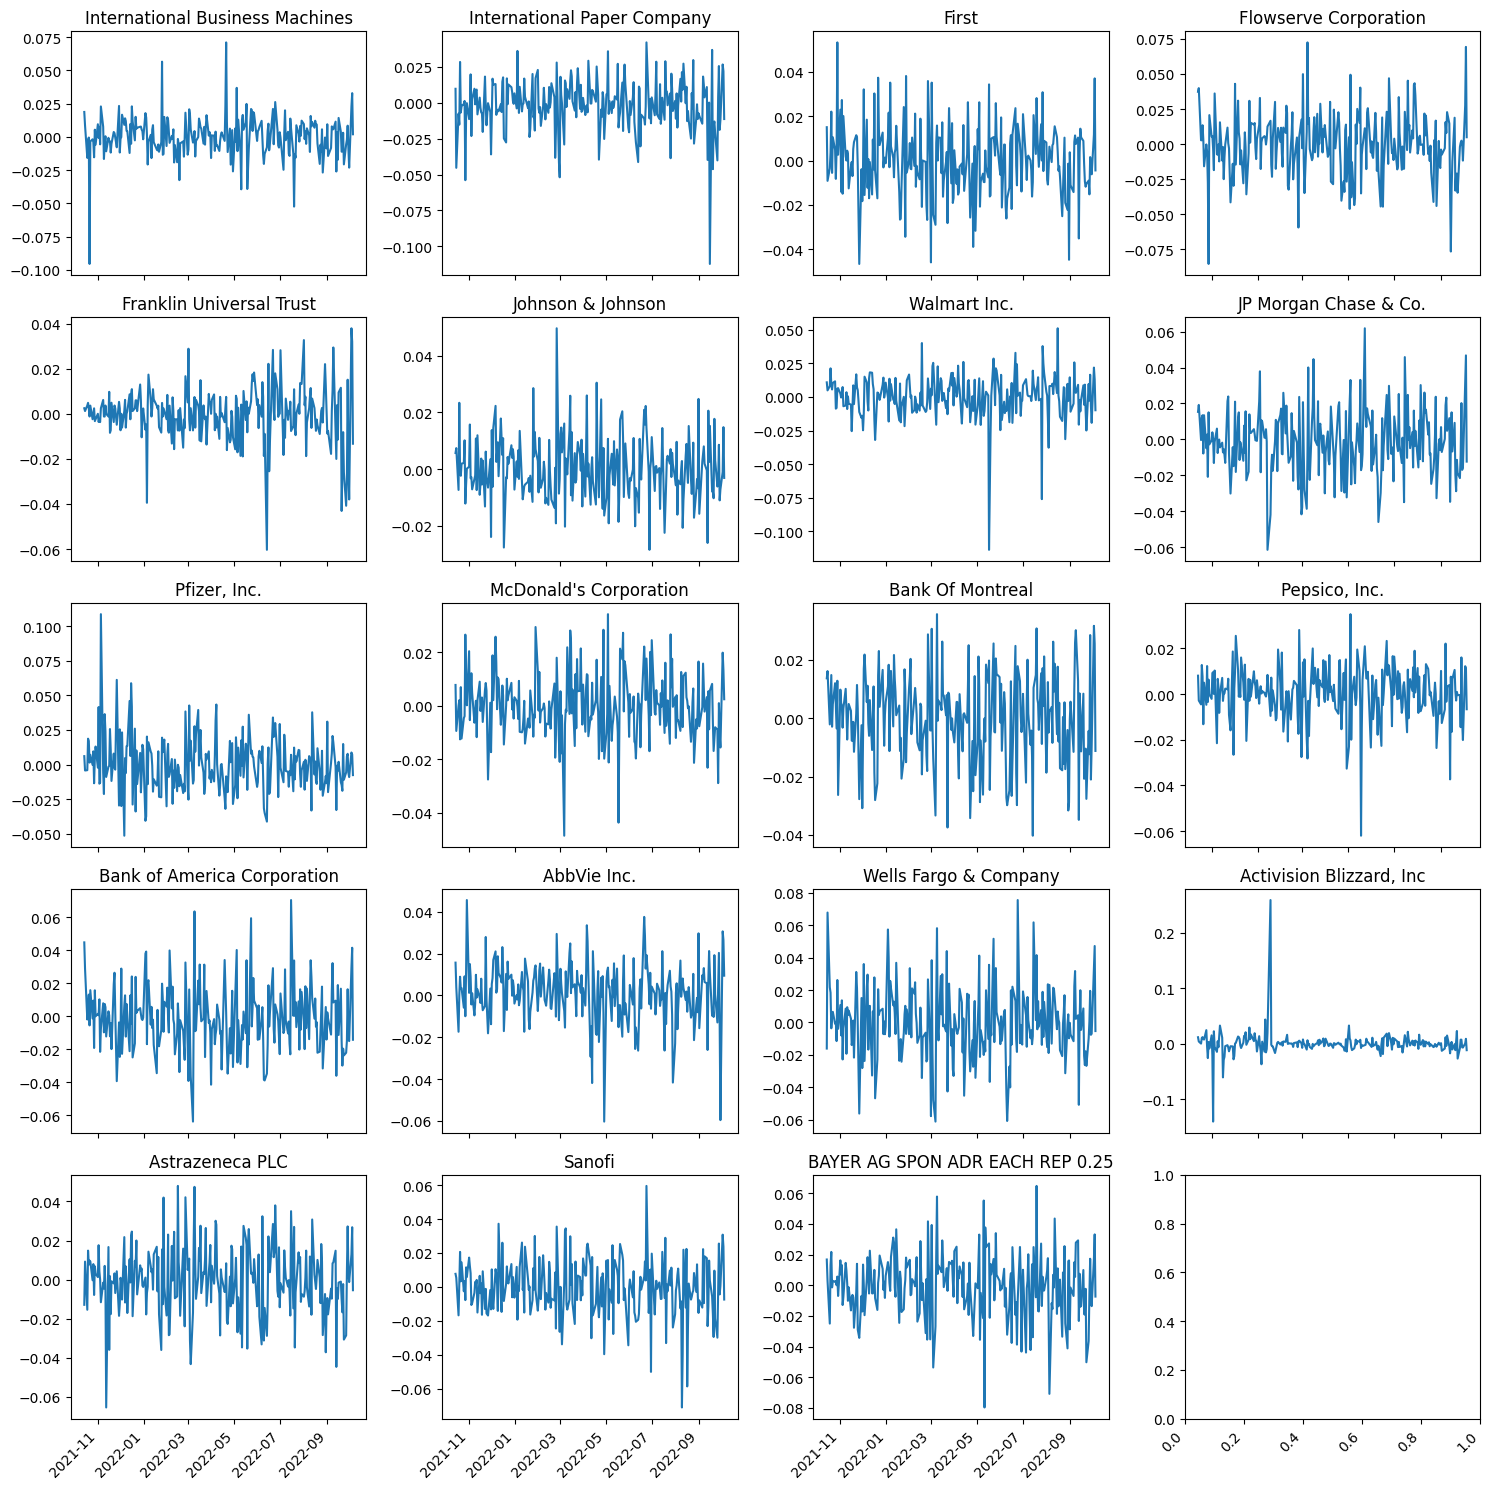

                          Cluster number: 2


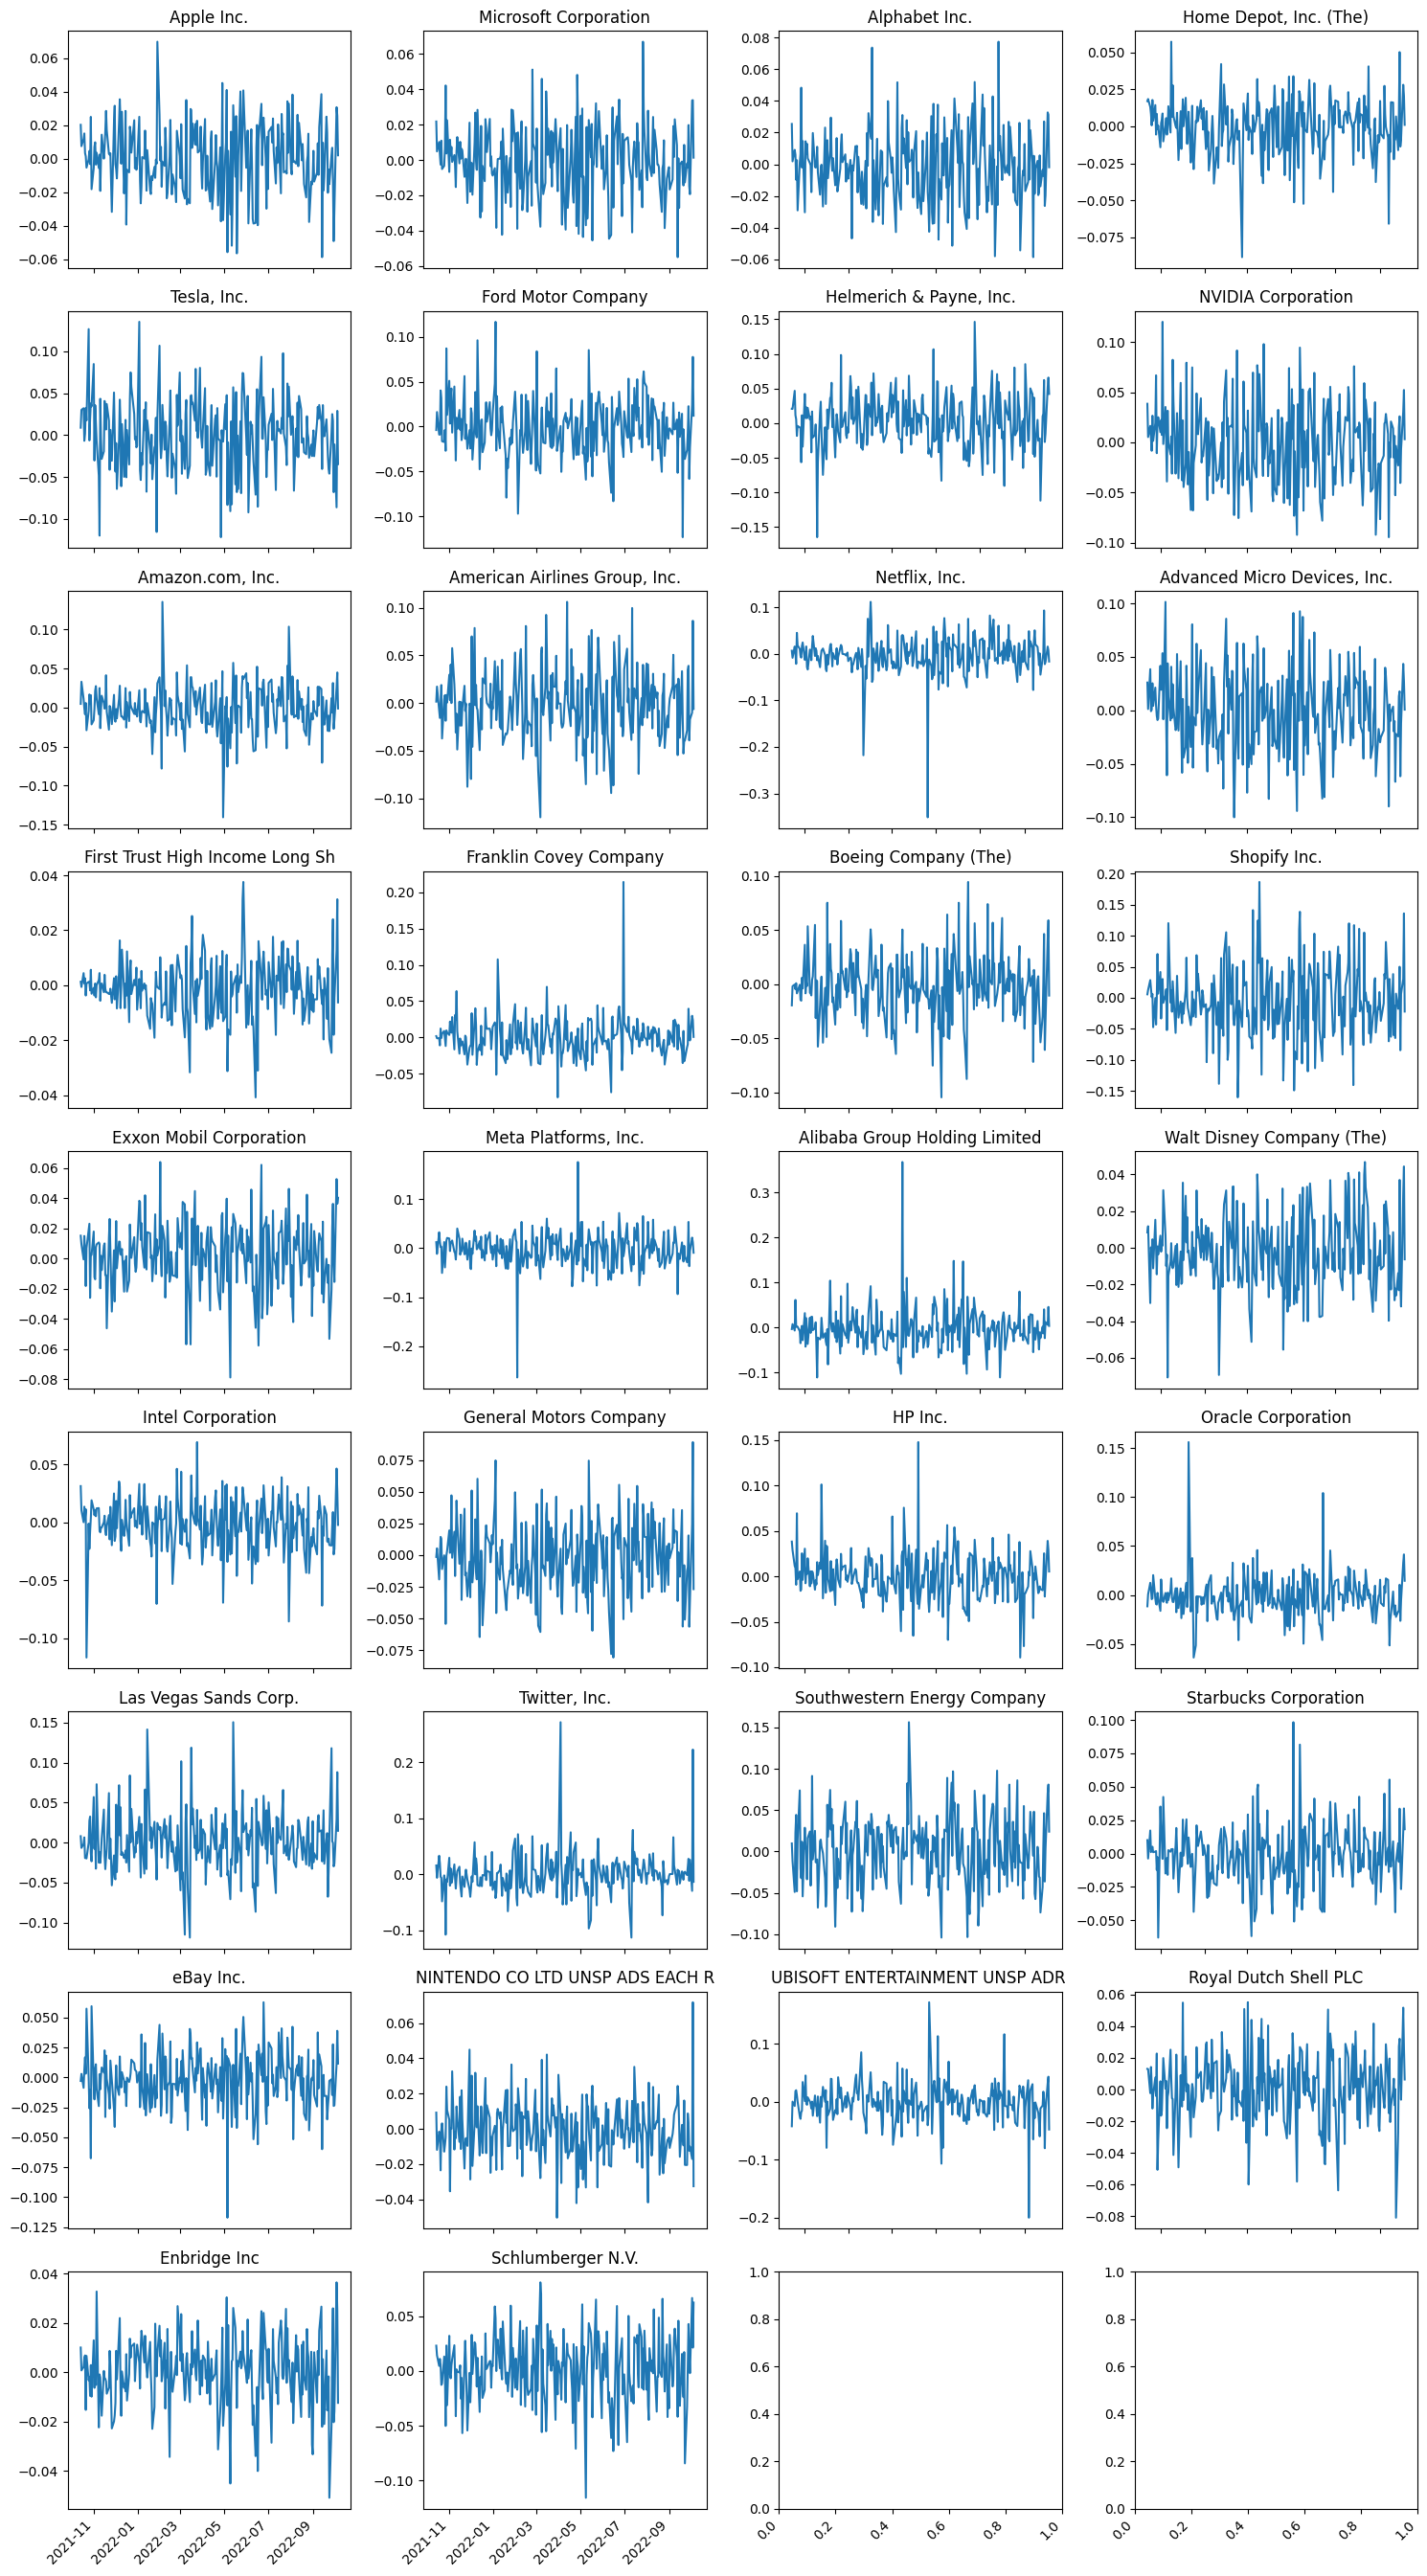

In [105]:
n_clusters_2 = 2
for cluster in range(1,n_clusters_2+1):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df_2[full_ticker_df_2.cluster==cluster])